3 Steps fot finding similar items:
1. Shingling: Converts a document into a set representation (Boolean vector)
2. Min-Hashing: Convert large sets to short signatures, while preserving similarity
3. Locality-Sensitive Hashing: Focus on pairs of signatures likely to be from
similar documents: candidate pairs

In [1]:
!pip install -U -q PyDrive

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1q-0N3l5O1d_RBrC_c-UlxmABH-xIVBH5'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('tactic_evals.csv')

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def onebyte_hash(s):
    return hash(s) % (256 * 4)

#Step 1: Shingling: Converts a document into a set
def k_token(text, k):
    output = []
    for i in range(len(text)-k +1):
        shingle = text[i:i + k]
        hashed_shingle = onebyte_hash(shingle)
        output.append(hashed_shingle)
    return output

#Step 2 Minhashing(creating signatures)
def minhash(matrix, permuted_indices, all_shingles):
    num_columns = matrix.shape[1]
    minhash_values = np.full(num_columns, np.inf)
    for i, permuted_row_index in enumerate(permuted_indices):
        for col in range(num_columns):
            if matrix[permuted_row_index, col] == 1:
                if minhash_values[col] == np.inf:
                    minhash_values[col] = all_shingles[permuted_row_index]
    return minhash_values

def create_signatures(matrix, num_permutations, all_shingles):
    num_columns = matrix.shape[1]
    signatures = np.zeros((num_permutations, num_columns))
    for i in range(num_permutations):
      permuted_indices = np.random.permutation(matrix.shape[0])
      minhash_values = minhash(matrix, permuted_indices, all_shingles)
      signatures[i, :] = minhash_values
    return signatures

#Step 3 LSH (candidate pairs in the same buckets)
def LSH(signatures, num_bands, rows_per_band, num_buckets):
    num_columns = signatures.shape[1]
    candidate_pairs = set()
    for band in range(num_bands):
        buckets = {}
        for col in range(num_columns):
            start_row = band * rows_per_band
            end_row = start_row + rows_per_band
            band_signature = tuple(signatures[start_row:end_row, col])
            bucket_id = hash(band_signature) % num_buckets
            if bucket_id not in buckets:
                buckets[bucket_id] = []
            buckets[bucket_id].append(col)
        for bucket_columns in buckets.values():
            if len(bucket_columns) > 1:
                for i in range(len(bucket_columns)):
                    for j in range(i + 1, len(bucket_columns)):
                        candidate_pairs.add((bucket_columns[i], bucket_columns[j]))
    return candidate_pairs

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

total = 250
count = 0
text = []
document_contents = []

with open('tactic_evals.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        count += 1
        if count == 1:
          continue
        if count > total:
           break
        txt = row[0]
        k = 16
        hashed_shingle = set(k_token(txt, k))
        text.append(hashed_shingle)
        document_contents.append(txt)

all_shingles = sorted(set.union(*text))

matrix = np.zeros((len(all_shingles), len(text)), dtype=int)

for col_index, doc in enumerate(text):
    for row_index, shingle in enumerate(all_shingles):
        if shingle in doc:
            matrix[row_index, col_index] = 1


num_permutations = 100
signatures = create_signatures(matrix, num_permutations, all_shingles)

num_bands = 50
rows_per_band = 5
num_buckets = 20

candidate_pairs = LSH(signatures, num_bands, rows_per_band, num_buckets)

similarity_threshold = 0.5

def filter_similar_pairs(candidate_pairs, text, threshold):
    similar_pairs = []
    for (i, j) in candidate_pairs:
        set_i = text[i]
        set_j = text[j]
        similarity = jaccard_similarity(set_i, set_j)
        if similarity >= threshold:
            similar_pairs.append((i, j, similarity))
    return similar_pairs

similar_pairs = filter_similar_pairs(candidate_pairs, text, similarity_threshold)

def create_similarity_df(pairs, document_contents):
    data = []
    for i, j, sim in pairs:
        text1 = document_contents[i]
        text2 = document_contents[j]
        data.append((i, j, sim, text1, text2))
    if not data:
        return None
    similarity_df = pd.DataFrame(data, columns=["Doc 1", "Doc 2", "Similarity", "Doc 1 Text", "Doc 2 Text"])
    return similarity_df

similarity_df = create_similarity_df(similar_pairs, document_contents)

if similarity_df is not None:
    print(similarity_df)
else:
    print("No similar pairs found.")


    Doc 1  Doc 2  Similarity  \
0     154    169    0.560000   
1     161    165    0.562500   
2      54     56    0.511628   
3      53     55    0.500000   
4       8     64    0.555556   
5     196    205    0.500000   
6     172    177    0.509804   
7     171    188    0.509091   
8     117    119    0.519231   
9      58     60    0.520000   
10    187    202    0.508475   
11      9     64    0.537037   
12     76     79    0.528302   
13     28     38    0.500000   
14    103    109    0.510204   

                                           Doc 1 Text  \
0   1r2bk2/R5pp/2p1N1n1/3pP3/3P2P1/R6P/5PK1/1r6 b ...   
1   2kr3r/pp3Npp/4p3/2n5/4p3/2P5/P1P2PPP/R4RK1 b -...   
2   3b1R1k/7p/p5p1/2p3Pn/1p6/3P3R/PP2rPK1/8 b - - ...   
3   3b3k/5R1p/p5p1/2p3Pn/1p6/3P3R/PP2rPK1/8 w - - ...   
4   1R3k2/4n1b1/3N1r1p/r2b2p1/2p5/3p4/P4PPP/2B1R1K...   
5   5k2/1pp4p/p5p1/3Qb3/8/P1P2P2/1P4PP/1q2B1K1 w -...   
6   4r1k1/Q4p1p/3b1qp1/8/3p4/P2B2P1/2P2P1P/6K1 w -...   
7   r2rR1k1/Q4p1p/3b1qp1/8/3p4/

# **Visual examples: **
 3b1R1k/7p/p5p1/2p3Pn/1p6/3P3R/PP2rPK1/8 b - - ...  
 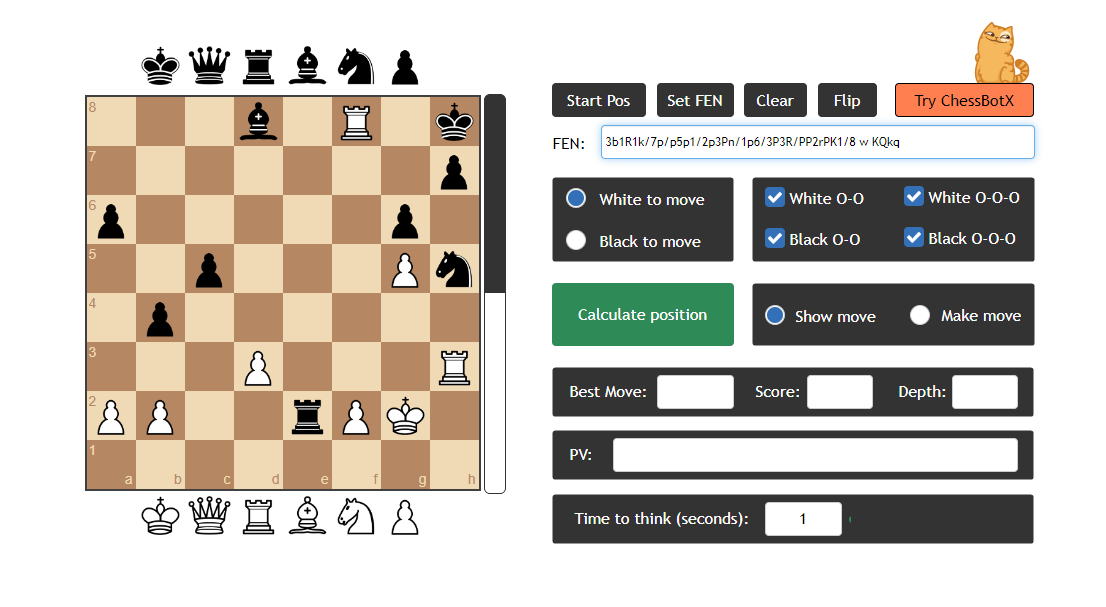
---
3R4/6kp/p5p1/2p3Pn/1p6/3P3R/PP2rPK1/8 b - - 0 46  
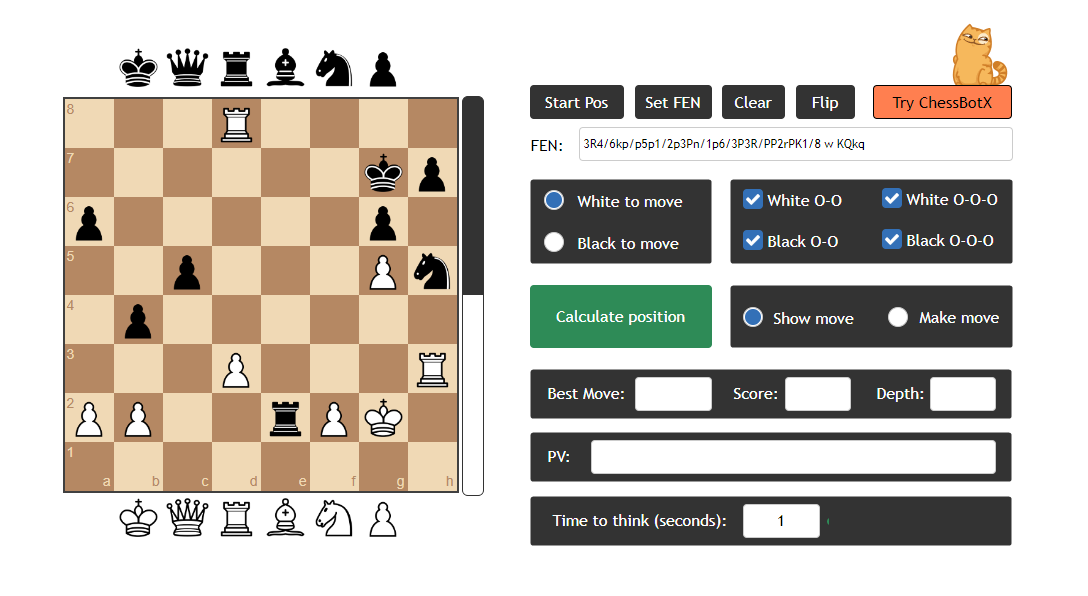


---

